# [out of date] Geographic analysis of patient flow

This notebook uses a geographic approach to **analyze the patient flow** through the municipalities in the Brazilian states. The first part of the analysis will be based on creating a **Voronoi diagram** from the centroids of municipalities defined as major healthcare poles. We will start with geographical distance but later refine it to road/highway-based distance. From this, we will obtain a Voronoi cell for each pole and observe whether patients are moving or not to the nearest pole to receive the health service. 

By analyzing the evolution of these data over the past 20 years for each Brazilian state, we can **evaluate the effectiveness of the regionalization process** in different regions of the country and in different moments of our recent history.

## Task Organization

1. Define the Voronoi seeds and plot the Voronoi diagram over the state map   

2. Create the origin-destination matrix and calculate the entropy   

3. Analyze the same matrix to other years  

4. Analyze the same visualization and matrix to other Brazilian states  
  
---

### Part 1: Define the Voronoi seeds and plot the Voronoi diagram over the state map

- Found the centroid point for each municipality pole***** for the chosen Brazilian state (Bahia - BA)
- Plot the Voronoi diagram using these points as seeds
- Add the geographic map of the state as a layer 

  
#### * for now, we define a _Municipality Pole_ as the municipality receiving more patients for each health region

#### Import and save the IBGE municipalities data

source (using 2019*): https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais

*buscar a malha territorial para os outros anos (2000, 2005, 2010, 2015-2019), quando necessario

#### Import the patient flow data and restrict the Voronoi seeds to the municipalities pole

In [5]:
import pandas as pd 

# read patient flow data for each Brazilian state and year (from 1998 to 2017)
data = pd.read_csv("data/sih_mun_pairs_1998_2017.csv", usecols=['year', 'UF', 'CODMUN_ocor', 'CODMUN_res', 'nhospadm_total']) 

# filter data when there are any hospitalization (removing empty flows)
flow_data = data.dropna()

# filter the dataset to Bahia
is_BA = flow_data['UF']=='BA'
BA_flow_data = flow_data[is_BA]

# filter the dataset only to year 1998
is_BA_1998 = BA_flow_data['year']==1998
BA_flow_data_1998 = BA_flow_data[is_BA_1998]

BA_flow_data_1998.head()

year  UF  CODMUN_ocor  CODMUN_res  nhospadm_total
14998  1998  BA       290100      290010             1.0
15406  1998  BA       290020      290020           866.0
15423  1998  BA       290160      290020             2.0
15829  1998  BA       290070      290030             6.0
15863  1998  BA       290330      290030            10.0

In [6]:
# get municipalities flows
flows = np.array(BA_flow_data_1998).T[[2, 3, 4]].T.astype('int') 

flows

array([[290100, 290010,      1],
       [290020, 290020,    866],
       [290160, 290020,      2],
       ...,
       [293350, 293350,   1930],
       [293360, 293350,      1],
       [293360, 293360,   5914]])

In [7]:
# get the number of hospitalizations each municipality had
unique_flows = np.zeros((np.unique(flows.T[1]).shape[0], 2), dtype='int')
curr_code = flows[0][1]
i = 0

for flow in flows:
    if flow[1] != curr_code:
        curr_code = flow[1]
        i += 1
    unique_flows[i][0] = flow[1]
    unique_flows[i][1] += flow[2]

unique_flows

array([[290010,      1],
       [290020,    868],
       [290030,     17],
       [290035,    140],
       [290040,      4],
       [290050,    140],
       [290060,    461],
       [290070,   3969],
       [290080,   1435],
       [290090,    172],
       [290100,   2055],
       [290110,    141],
       [290115,   1085],
       [290120,      4],
       [290130,      1],
       [290135,     12],
       [290140,    931],
       [290160,   2515],
       [290180,    474],
       [290190,   1272],
       [290200,    595],
       [290205,    600],
       [290210,   2768],
       [290220,    221],
       [290225,    795],
       [290230,      1],
       [290240,    850],
       [290250,   1590],
       [290260,   1145],
       [290265,    166],
       [290270,   1475],
       [290280,   2406],
       [290290,   1349],
       [290300,   1408],
       [290310,    920],
       [290320,  14634],
       [290323,    861],
       [290330,   1044],
       [290340,   3239],
       [290350,      1],


In [142]:
# get the municipalities pole, where each health region contains just one pole

if len(regions[0][0]) < 8:
    for region in regions:
        for i_mun in range(len(region)):
            rows = np.where(unique_flows.T[0] == region[i_mun][0])[0]
            if rows.shape[0]:
                region[i_mun].append(unique_flows[rows[0]][1])
            else:
                region[i_mun].append(0)

poles = []

for i_reg in range(len(regions)):
    hospitalizations = np.array(np.array(regions[i_reg]).T[-1], dtype='int')
    i_max_hosp = np.argmax(hospitalizations)
    poles.append(np.array(regions[i_reg][i_max_hosp]))
    
poles = np.array(poles)

In [143]:
# plot map and centroids
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(poles.T[2]).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(poles.T[3]).plot(ax=ax, markersize=2, color="red")
ax.axis("off")
plt.title("Pole municipalities in the State of Bahia")
plt.show()

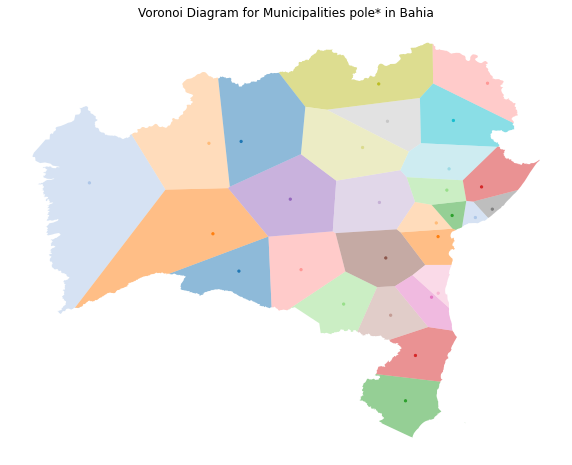

In [144]:
from geovoronoi import points_to_coords, voronoi_regions_from_coords
from geovoronoi.plotting import plot_voronoi_polys_with_points_in_area


state_boundary = cascaded_union(municipalities.T[2])
poles_coords = points_to_coords(poles.T[3])

# calculate Voronoi cells
voronoi_cells, seeds, cell_to_seed_assignments = voronoi_regions_from_coords(poles_coords, state_boundary)

# plot Voronoi cells 
fig, ax = plt.subplots(figsize=(10, 8))
plot_voronoi_polys_with_points_in_area(ax, state_boundary, voronoi_cells, seeds, 
                                       cell_to_seed_assignments, area_edgecolor='white')

ax.set_title('Voronoi Diagram for Municipalities pole* in Bahia')
ax.axis("off")
plt.show()

---
### Part 2: Create the origin-destination matrix and calculate the entropy 

- Create the OD matrix in a specific year, where each line _i_ contains the number of patients residing in a Voronoi cell _i_ going to each Voronoi cell _j_
- Calculate the entropy of each line 

In [145]:
from geovoronoi import assign_points_to_voronoi_polygons

# create relation between the Voronoi cell and the municipalities it contains
#  where the ith position in the array contain the municipalities indexes that the ith cell contains
assignments = assign_points_to_voronoi_polygons(municipalities.T[3], voronoi_cells)

municipalities_pole = np.zeros(municipalities.shape[0])
pole_shapes = np.empty(municipalities.shape[0]).astype('object')

pole_indexes = np.array(cell_to_seed_assignments).T[0]

for cell_i in range(len(voronoi_cells)):
    pole_code = poles.T[0][pole_indexes[cell_i]]
    
    for seed_i in range(len(assignments[cell_i])):
        municipalities_pole[assignments[cell_i][seed_i]] = pole_code
        pole_shapes[assignments[cell_i][seed_i]] = voronoi_cells[cell_i]
        
municipalities_pole = municipalities_pole.astype('int')

# municipalities [CODE, NAME, SHAPE, CENTROID_POINT, POLE_CODE, POLE_SHAPE, REGION_NAME]
municipalities = municipalities.T[:-1].T
municipalities = np.c_[municipalities, municipalities_pole, pole_shapes, region_columns]

In [146]:
def getPoleIndex(code):
    row, col = np.where(municipalities == code)
    row, col = np.where(poles == municipalities[row[np.where(col == 0)[0][0]]][4])
    return row[np.where(col == 0)[0][0]]

In [147]:
# get municipalities flows
flows = np.array(BA_flow_data_1998).T[[2, 3, 4]].T.astype('int') 

pole_flows = np.empty(flows.shape).astype('int')

# get pole flows
for i in range(flows.shape[0]):
    pole_flows[i][0] = getPoleIndex(flows[i][1])
    pole_flows[i][1] = getPoleIndex(flows[i][0])
    pole_flows[i][2] = flows[i][2]

pole_flows

array([[  21,    2,    1],
       [  15,   15,  866],
       [  18,   15,    2],
       ...,
       [  26,   26, 1930],
       [   9,   26,    1],
       [   9,    9, 5914]])

In [148]:
# create a origin-destination matrix
OD_matrix = np.zeros((poles.shape[0], poles.shape[0])).astype('int')
for flow in pole_flows:
    OD_matrix[flow[0]][flow[1]] += flow[2]
OD_matrix

array([[ 17909,      0,      1,    420,      1,      2,      0,      0,
             0,      0,      0,      0,      1,      0,      3,      0,
             0,      0,      5,    327,      0,      0,      0,      0,
            17,      1,      0,      0],
       [     4,  20652,      0,      0,      0,      1,      0,    161,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,     30,      1,      3,      2,
             0,      0,      0,      1],
       [     0,      0,  13046,      0,      0,      0,      6,      0,
             0,      0,      0,      0,      1,      0,      1,      0,
             0,      0,      0,      0,      2,      0,    271,      2,
             0,      0,      0,     89],
       [    65,      0,      0,   9150,      1,      1,      0,      0,
             0,      2,      0,      0,      7,      1,      0,      1,
             0,      0,      0,     34,      0,      0,      0,      0,
             

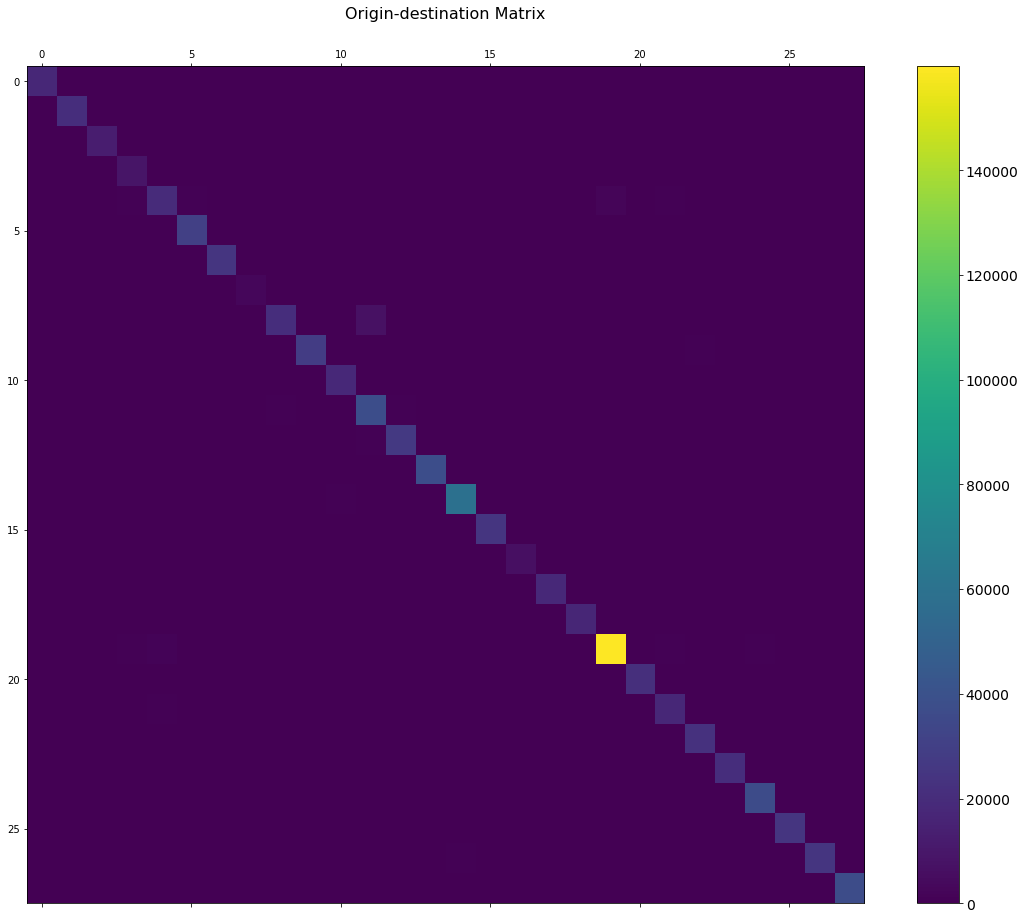

In [149]:
f = plt.figure(figsize=(19, 15))
plt.matshow(OD_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-destination Matrix', fontsize=16)
plt.show()

In [150]:
# here, each line is divided by its largest flow number
new_OD_matrix = OD_matrix.astype('float')

for i in range(OD_matrix.shape[0]):
    new_OD_matrix[i] = new_OD_matrix[i]/float(new_OD_matrix[i].max())

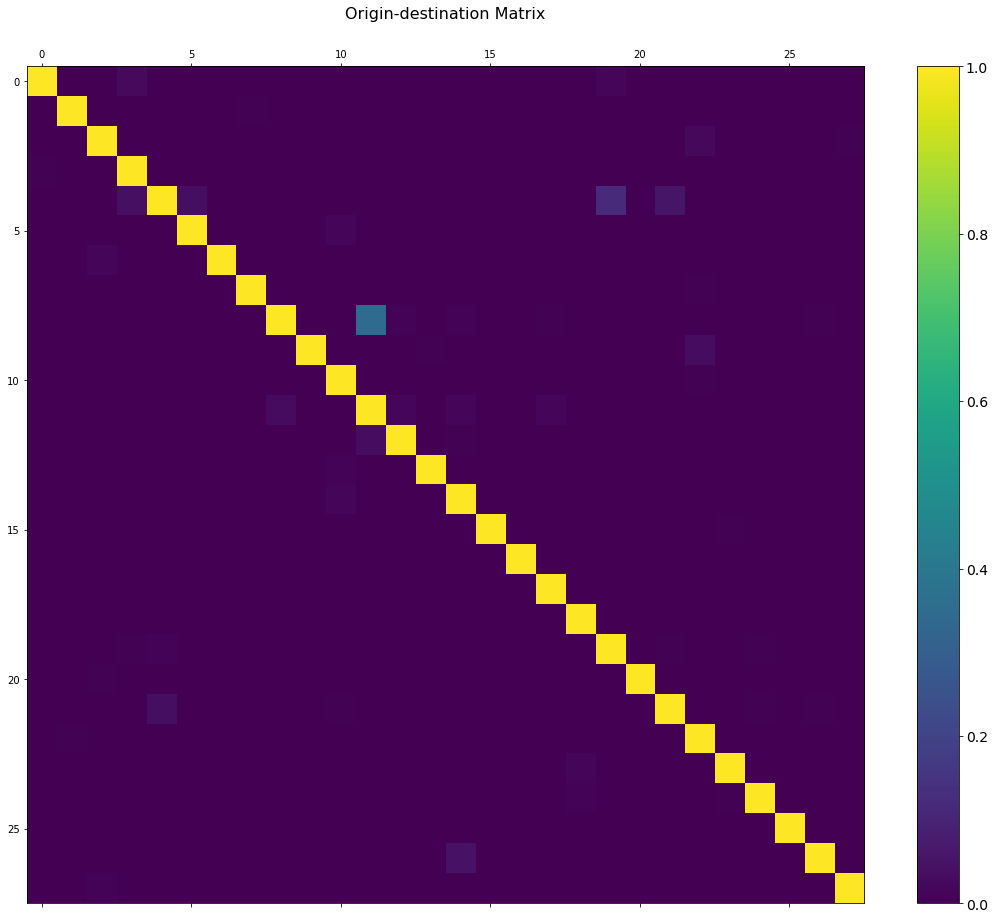

In [151]:
f = plt.figure(figsize=(19, 15))
plt.matshow(new_OD_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-destination Matrix', fontsize=16)
plt.show()

#### Calculate the entropy of each line

In [152]:
from scipy.stats import entropy

poles_entropy = np.c_[poles.T[1], entropy(new_OD_matrix, axis=1)]

poles_entropy

array([['Alagoinhas', 0.20990748040742133],
       ['Barreiras', 0.061881817579668964],
       ['Brumado', 0.14690923511202078],
       ['Camaçari', 0.08062757844918284],
       ['Maragogipe', 0.8031113610902483],
       ['Feira de Santana', 0.17692543315257067],
       ['Guanambi', 0.1165131392454877],
       ['Barra', 0.055283223668303114],
       ['Ilhéus', 0.7256378622223751],
       ['Xique-Xique', 0.18272707664770385],
       ['Itaberaba', 0.0762608648644149],
       ['Itabuna', 0.38250001189559135],
       ['Itapetinga', 0.21371583770459998],
       ['Jacobina', 0.08794941917327309],
       ['Jequié', 0.14348523824420312],
       ['Juazeiro', 0.0784345393933395],
       ['Paulo Afonso', 0.006092939332568303],
       ['Eunápolis', 0.018630768402268072],
       ['Euclides da Cunha', 0.034788401441325424],
       ['Salvador', 0.27882653234257926],
       ['Bom Jesus da Lapa', 0.055317667902940695],
       ['Santo Antônio de Jesus', 0.27044345026424094],
       ['Seabra', 0.06005092

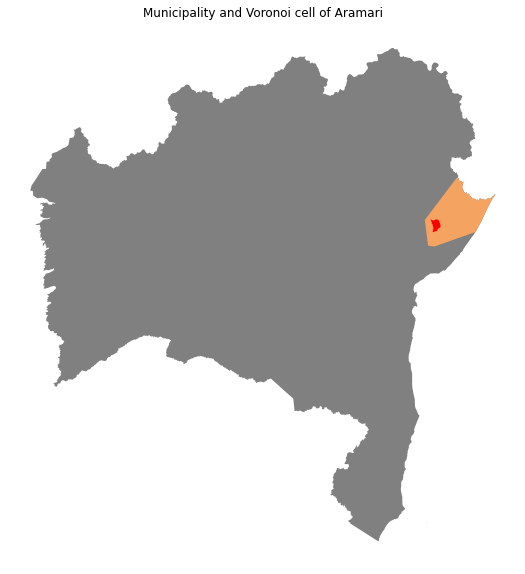

In [153]:
# plot a pole municipality and its Voronoi cell
mun = 26
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(state_boundary).plot(ax=ax, color="gray")
gpd.GeoSeries(municipalities[mun][5]).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(municipalities[mun][2]).plot(ax=ax, color="red")
ax.axis("off")
plt.title("Municipality and Voronoi cell of " + municipalities[mun][1])
plt.show()

In [154]:
_, unique = np.unique(municipalities.T[4], return_index=True)
voronoi_shapes = municipalities.T[5][unique]

geo_voronoi = gpd.GeoDataFrame({'geometry': voronoi_cells, 'entropy': poles_entropy.T[1]})

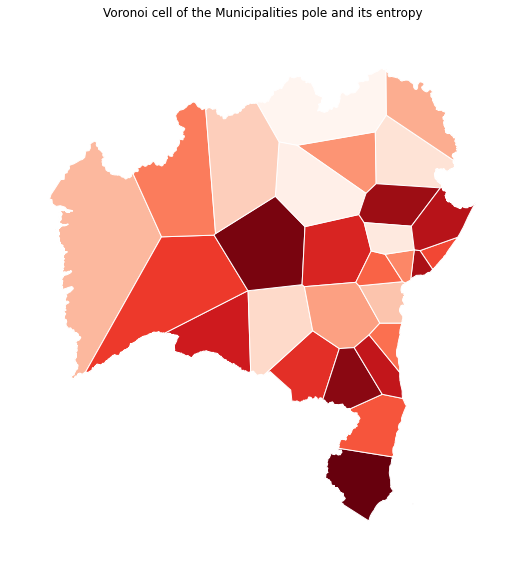

In [155]:
import geoplot

geoplot.choropleth(
    geo_voronoi, hue='entropy',
    edgecolor='white', linewidth=1,
    cmap='Reds', figsize=(12, 10)
)
plt.title('Voronoi cell of the Municipalities pole and its entropy')
plt.show()

---
### Part 3: Analyze the same matrix to other years

- Analyze the created matrix and the municipalities entropy in other years  